In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

import biff
from pygadgetreader import *
from octopus import profiles
from octopus import orbit_cm
from astropy import constants
from astropy import units as u

from octopus import profiles

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
G_c = constants.G
G_c = G_c.to(u.kiloparsec**3 / (u.s**2 * u.Msun)) # 
print G_c

4.51835939627e-39 kpc3 / (s2 solMass)


In [3]:
font = {'size':16, 'family':'serif'}
plt.matplotlib.rc('font', **font)

## To-Do:

1. Check Mass of MW+LMC 
2. Check scatter plot with potential colorbar
3. Check 1.5 factor in potential and sqrt(1\pi)/1.5 in acceleration
4. Locate the LMC in the HEx potential

In [4]:
MWLMCi = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'pos', 'dm')
MWLMCi_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'mass', 'dm')
MWLMCi_pot = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_000.hdf5', 'pot', 'dm')

MWLMCf = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pos', 'dm')
MWLMCf_vel = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'vel', 'dm')
MWLMCf_pid = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pid', 'dm')
MWLMCf_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'mass', 'dm')
MWLMCf_pot = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pot', 'dm')

Returning DM    Positions
Returning DM    Mass
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Mass
Returning DM    Potential


In [5]:
xmw_cm = 3.14213492468
ymw_cm = 33.1085245965
zmw_cm = -10.5106429199

In [6]:
MWLMCf[:,0] = MWLMCf[:,0] - xmw_cm
MWLMCf[:,1] = MWLMCf[:,1] - ymw_cm
MWLMCf[:,2] = MWLMCf[:,2] - zmw_cm

In [7]:
trunc2 = np.where(np.sqrt((MWLMCi[:,0])**2.0 + (MWLMCi[:,1])**2.0 + (MWLMCi[:,2])**2.0)<500)[0]
trunc3 = np.where(np.sqrt((MWLMCf[:,0])**2.0 + (MWLMCf[:,1])**2.0 + (MWLMCf[:,2])**2.0)<500)[0]

In [8]:
MWLMCi_t = MWLMCi[trunc2]
MWLMCi_mass_t = MWLMCi_mass[trunc2]
MWLMCi_pot_t = MWLMCi_pot[trunc2]

MWLMCf_t = MWLMCf[trunc3]
MWLMCf_mass_t = MWLMCf_mass[trunc3]
MWLMCf_pot_t = MWLMCf_pot[trunc3]

In [9]:
## Code taken from (https://github.com/adrn/biff/blob/master/notebooks/Plummer%20test.ipynb)
def STnlm(xyz, mass, rs, n_max, l_max):
    nmax = n_max
    lmax = l_max

    Snlm = np.zeros((nmax+1,lmax+1,lmax+1))
    Tnlm = np.zeros((nmax+1,lmax+1,lmax+1))

    nlms = []

    for n in range(nmax+1):
        for l in range(lmax+1):
            for m in range(l+1):
                nlms.append([n,l,m])

    for nlm in nlms:
        n,l,m = nlm
        S,T = biff.compute_coeffs_discrete(np.double(xyz), np.double(mass/100.0), nlm, rs)
        Snlm[n,l,m] = S
        Tnlm[n,l,m] = T
    return Snlm, Tnlm, nlms

In [10]:
# Function to write the coefficients.
def writting_coeff(name, S, T):
    f = open(name, 'w')
    f.write("# S    T \n")
    S1d = np.reshape(S, (np.size(S),1))
    T1d = np.reshape(T, (np.size(T),1))
    for i in range(len(S1d)):
        f.write("%f %f \n"%(S1d[i][0], T1d[i][0]))
    f.close

# MW + LMC initial state

In [83]:
r_MWLMCi_t = np.sqrt(MWLMCi_t[:,0]**2.0 + MWLMCi_t[:,1]**2.0 + MWLMCi_t[:,2]**2.0)
r_MWLMCf_t = np.sqrt(MWLMCf_t[:,0]**2.0 + MWLMCf_t[:,1]**2.0 + MWLMCf_t[:,2]**2.0)

In [12]:
SMWLMCi1, TMWLMCi1, nlmsMWLMCi1 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 1, 0)

MWLMCbfe_pot = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi1, TMWLMCi1, 1, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi1, TMWLMCi1, 1, 0, 1.55E12, 40.85)

In [13]:
SMWLMCi2, TMWLMCi2, nlmsMWLMCi2 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 10, 0)

MWLMCbfe_pot2 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi2, TMWLMCi2, 10, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho2 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi2, TMWLMCi2, 10, 0, 1.55E12, 40.85)

In [14]:
SMWLMCi3, TMWLMCi3, nlmsMWLMCi3 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 20, 0)

MWLMCbfe_pot3 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi3, TMWLMCi3, 20, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho3 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi3, TMWLMCi3, 20, 0, 1.55E12, 40.85)

In [15]:
SMWLMCi4, TMWLMCi4, nlmsMWLMCi4 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 5, 5)


In [16]:
MWLMCbfe_pot4 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi4, TMWLMCi4, 5, 5, G_c.value, 1.55E12, 40.85)
#MWLMCbfe_rho4 = biff.density(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi4, TMWLMCi4, 5, 5, 1.55E12, 40.85)

In [ ]:
SMWLMCi5, TMWLMCi5, nlmsMWLMCi5 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 10, 10)
MWLMCbfe_pot5 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi5, TMWLMCi5, 10, 10, G_c.value, 1.55E12, 40.85)


In [17]:
SMWLMCi6, TMWLMCi6, nlmsMWLMCi6 = STnlm(MWLMCi_t, MWLMCi_mass_t, 40.3, 20, 20)
MWLMCbfe_pot6 = biff.potential(np.ascontiguousarray(np.double(MWLMCi_t)), SMWLMCi6, TMWLMCi6, 20, 20, G_c.value, 1.55E12, 40.85)


In [ ]:
writting_coeff('MWLMC1-n1', SMWLMCi1, TMWLMCi1)
writting_coeff('MWLMC1-n10', SMWLMCi2, TMWLMCi2)
writting_coeff('MWLMC1-n20', SMWLMCi3, TMWLMCi3)
writting_coeff('MWLMC1-n5-l5', SMWLMCi4, TMWLMCi4)
writting_coeff('MWLMC1-n10-l10', SMWLMCi5, TMWLMCi5)
writting_coeff('MWLMC1-n20-l20', SMWLMCi6, TMWLMCi6)

In [20]:
# From Gadget units to physical units in kpc, Msun and s
pot_factor = G_c/43007.1*1E10

In [18]:
def pot_contour(x, y, pot, n_bins):
    x_pot = np.linspace(min(x), max(x), n_bins)
    y_pot = np.linspace(min(y), max(y), n_bins)
    pot_grid = np.zeros((n_bins,  n_bins))

    for i in range(1,n_bins):
        for j in range(1,n_bins):
            index = np.where((x<x_pot[i]) & (x>x_pot[i-1]) & (y<y_pot[j]) & (y>y_pot[j-1]))[0]
            pot_grid[i][j] = np.mean(pot[index])
    return x_pot, y_pot, pot_grid

In [47]:
pot_factor = G_c/43007.1*1E10 
x_MWLMC1, y_MWLMC1, potMWLMC1 = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMCi_pot_t*pot_factor.value, 200)

In [38]:
y2_MWLMC1, z2_MWLMC1, potMWLMCyz = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMCi_pot_t*pot_factor.value, 100)

In [84]:
bulge_pot_hex = profiles.pot_hernquist(0.7, r_MWLMCi_t, 1.4E10)
disk_pot_hex = profiles.pot_mn(0.638, 2.9, r_MWLMCi_t, 0, 0, 5.78E10)

bulge_potf_hex = profiles.pot_hernquist(0.7, r_MWLMCf_t, 1.4E10)
disk_potf_hex = profiles.pot_mn(0.638, 2.9, r_MWLMCf_t, 0, 0, 5.78E10)
factor=1.5


In [54]:
MWLMC1_pot_b = MWLMCbfe_pot/factor + bulge_pot_hex + disk_pot_hex
MWLMC3_pot_b = MWLMCbfe_pot3/factor + bulge_pot_hex + disk_pot_hex
MWLMC4_pot_b = MWLMCbfe_pot4/factor + bulge_pot_hex + disk_pot_hex
MWLMC5_pot_b = MWLMCbfe_pot6/factor + bulge_pot_hex + disk_pot_hex

x_MWLMC2, y_MWLMC2, potMWLMC2 = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC1_pot_b, 100)
x_MWLMC4, y_MWLMC4, potMWLMC4 = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC3_pot_b, 100)
x_MWLMC5, y_MWLMC5, potMWLMC5 = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC4_pot_b, 100)
x_MWLMC6, y_MWLMC6, potMWLMC6 = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC5_pot_b, 100)

In [55]:
# YZ - PLane

y2_MWLMC2, z2_MWLMC2, potMWLMC2yz = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC1_pot_b, 100)
y2_MWLMC4, z2_MWLMC4, potMWLMC4yz = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC3_pot_b, 100)
y2_MWLMC5, z2_MWLMC5, potMWLMC5yz = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC4_pot_b, 100)
y2_MWLMC6, z2_MWLMC6, potMWLMC6yz = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC5_pot_b, 100)

In [56]:
## Res

MWLMC2_pot_res = (MWLMC1_pot_b - MWLMCi_pot_t*pot_factor.value)/(MWLMCi_pot_t*pot_factor.value)
MWLMC3_pot_res = (MWLMC3_pot_b - MWLMCi_pot_t*pot_factor.value)/(MWLMCi_pot_t*pot_factor.value)
MWLMC4_pot_res = (MWLMC4_pot_b - MWLMCi_pot_t*pot_factor.value)/(MWLMCi_pot_t*pot_factor.value)
MWLMC5_pot_res = (MWLMC5_pot_b - MWLMCi_pot_t*pot_factor.value)/(MWLMCi_pot_t*pot_factor.value)

x_MWLMC2_r, y_MWLMC2_r, potMWLMC2_r = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC2_pot_res, 100)
x_MWLMC4_r, y_MWLMC4_r, potMWLMC4_r = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC3_pot_res, 100)
x_MWLMC5_r, y_MWLMC5_r, potMWLMC5_r = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC4_pot_res, 100)
x_MWLMC6_r, y_MWLMC6_r, potMWLMC6_r = pot_contour(MWLMCi_t[:,0], MWLMCi_t[:,1], MWLMC5_pot_res, 100)

y2_MWLMC2_r, z2_MWLMC2_r, potMWLMC2yz_r = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC2_pot_res, 100)
y2_MWLMC4_r, z2_MWLMC4_r, potMWLMC4yz_r = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC3_pot_res, 100)
y2_MWLMC5_r, z2_MWLMC5_r, potMWLMC5yz_r = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC4_pot_res, 100)
y2_MWLMC6_r, z2_MWLMC6_r, potMWLMC6yz_r = pot_contour(MWLMCi_t[:,1], MWLMCi_t[:,2], MWLMC5_pot_res, 100)

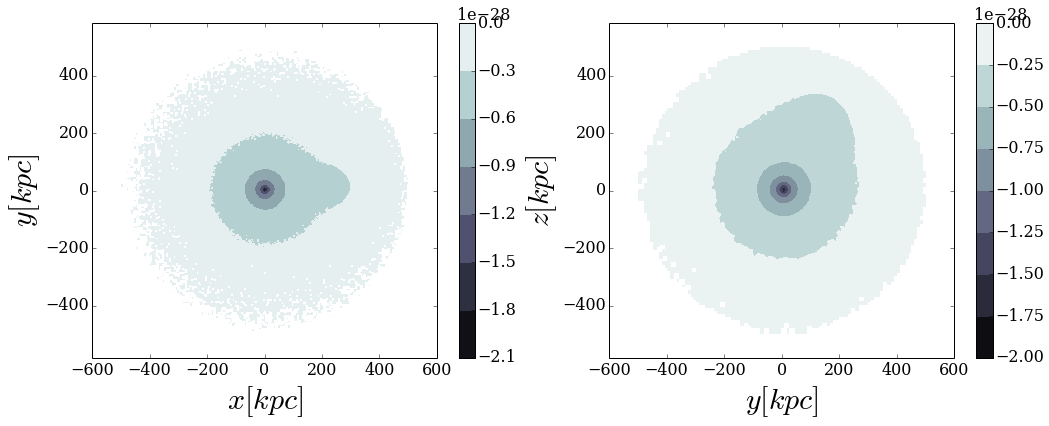

In [59]:
plt.figure(figsize=(17, 6))
plt.subplot(1,2,1)
plt.contourf(x_MWLMC1, y_MWLMC1, potMWLMC1, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
plt.ylabel('$y[kpc]$', fontsize=30)
plt.xlabel('$x[kpc]$', fontsize=30)
#plt.title('$\Phi_{N-Body}$', fontsize=35, y=1.05)

plt.subplot(1,2,2)
plt.contourf(y2_MWLMC1, z2_MWLMC1, potMWLMCyz, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
plt.ylabel('$z[kpc]$', fontsize=30)
plt.xlabel('$y[kpc]$', fontsize=30)

plt.savefig('LMCMWi_pot.png',dpi=300, bbox_inches='tight')



<matplotlib.colorbar.Colorbar instance at 0x7fd7100f78c0>

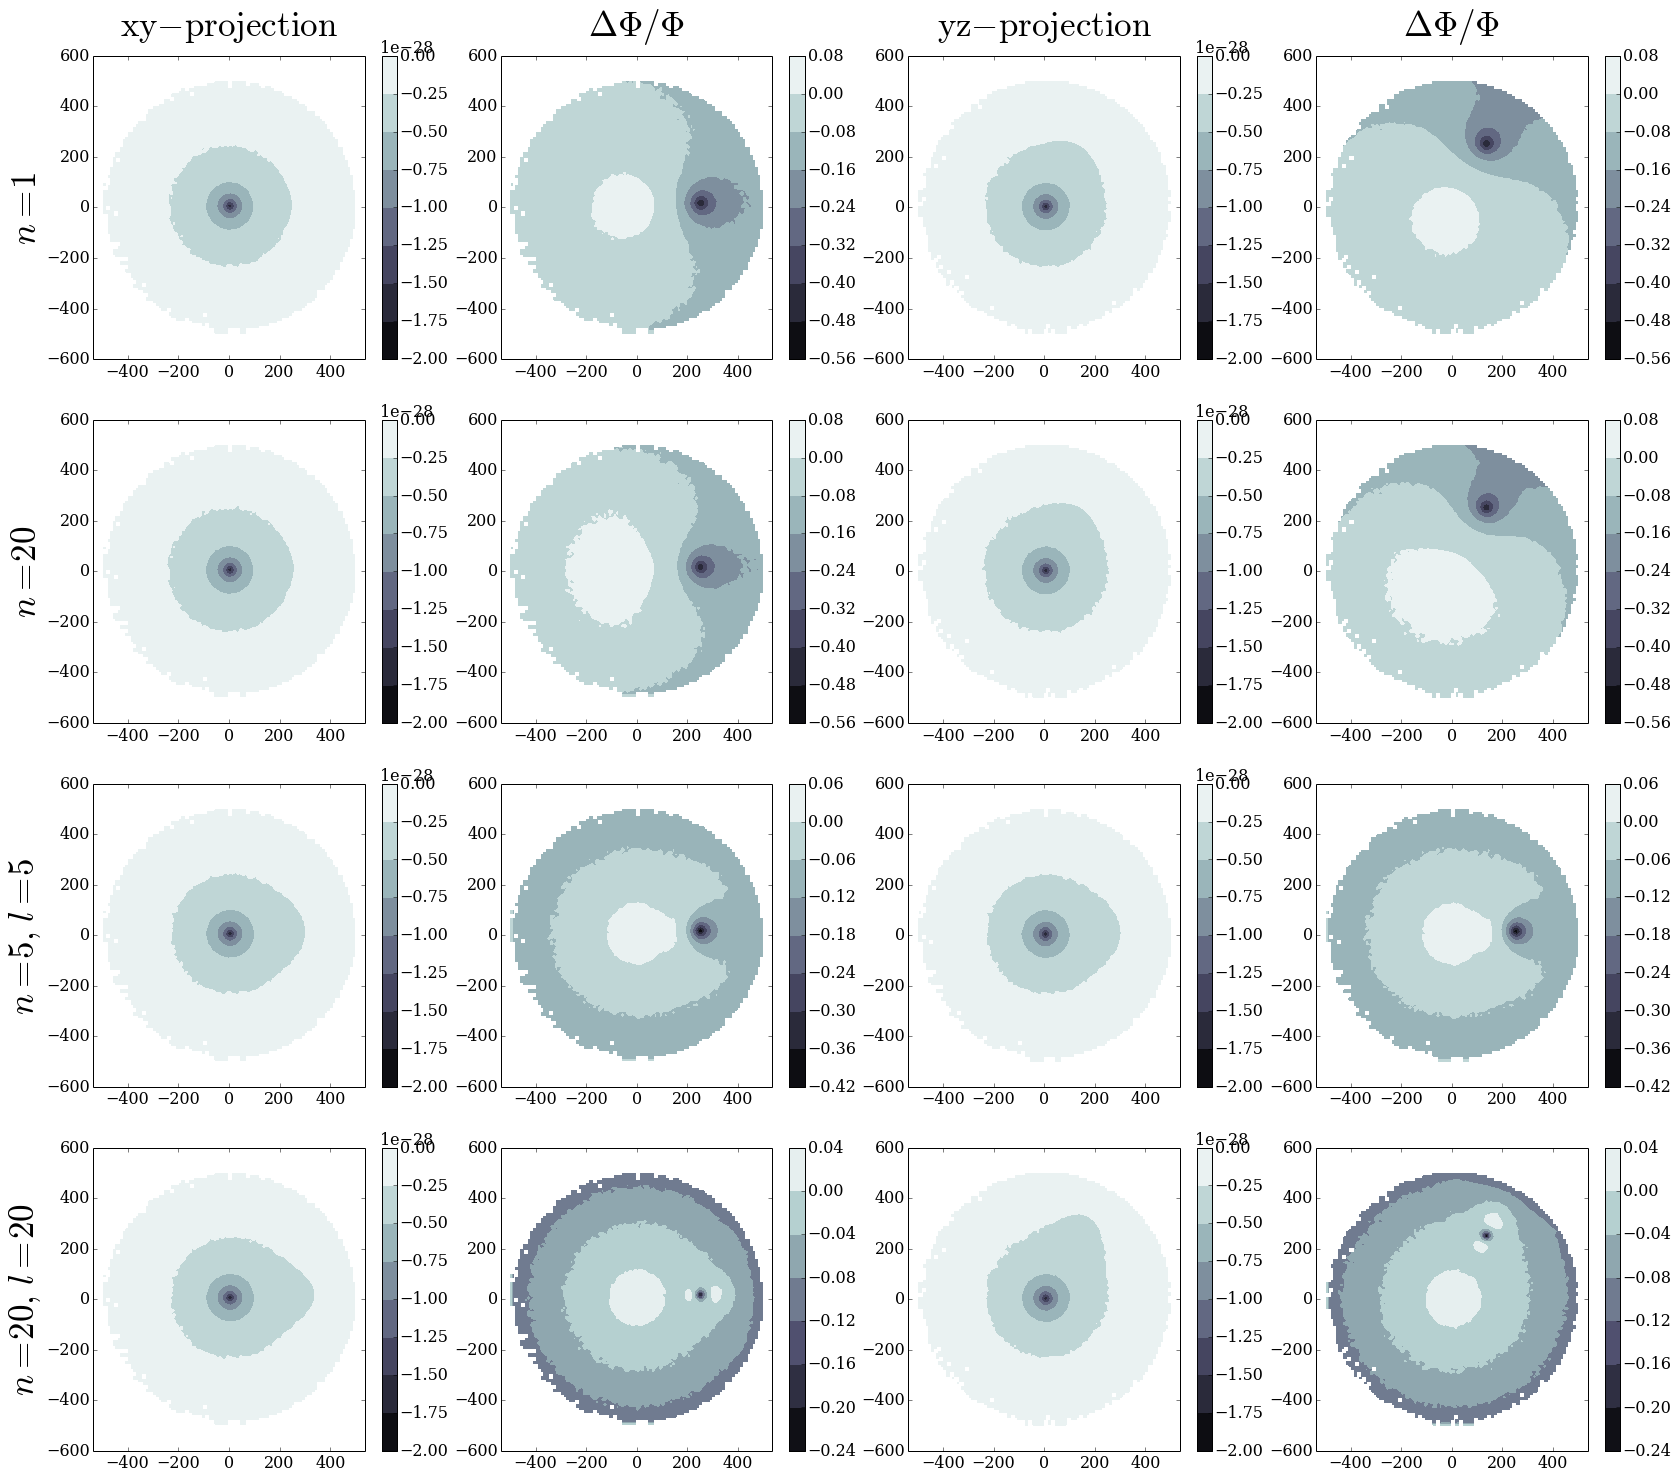

In [77]:
plt.figure(figsize=(28, 25))

plt.subplot(4,4,1)
plt.title('$\mathrm{xy-projection}$', fontsize=35, y=1.05)
plt.contourf(x_MWLMC2, y_MWLMC2, potMWLMC2, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=1$', fontsize=35)
plt.colorbar()

plt.subplot(4,4,2)
plt.title('$\Delta \Phi / \Phi$', fontsize=35, y=1.05)
plt.contourf(x_MWLMC2_r, y_MWLMC2_r, potMWLMC2_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,3)
plt.title('$\mathrm{yz-projection}$', fontsize=35, y=1.05)
plt.contourf(y2_MWLMC2, z2_MWLMC2, potMWLMC2yz, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,4)
plt.title('$\Delta \Phi / \Phi$', fontsize=35, y=1.05)
plt.contourf(y2_MWLMC2_r, z2_MWLMC2_r, potMWLMC2yz_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,5)
plt.contourf(x_MWLMC4, y_MWLMC4, potMWLMC4, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=20$', fontsize=35)
plt.colorbar()

plt.subplot(4,4,6)
plt.contourf(x_MWLMC4_r, y_MWLMC4_r, potMWLMC4_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,7)
plt.contourf(y2_MWLMC4, z2_MWLMC4, potMWLMC4yz, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,8)
plt.contourf(y2_MWLMC4_r, z2_MWLMC4_r, potMWLMC4yz_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,9)
plt.contourf(x_MWLMC5, y_MWLMC5, potMWLMC5, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=5,\ l=5$', fontsize=35)

plt.colorbar()

plt.subplot(4,4,10)
plt.contourf(x_MWLMC5_r, y_MWLMC5_r, potMWLMC5_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,11)
plt.contourf(y2_MWLMC5, z2_MWLMC5, potMWLMC5, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,12)
plt.contourf(y2_MWLMC5_r, z2_MWLMC5_r, potMWLMC5_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,13)
plt.contourf(x_MWLMC6, y_MWLMC6, potMWLMC6, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
plt.ylabel('$n=20,\ l=20$', fontsize=35)
#plt.xlabel('$x[kpc]$', fontsize=30)

plt.subplot(4,4,14)
plt.contourf(x_MWLMC6_r, y_MWLMC6_r, potMWLMC6_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)

plt.subplot(4,4,15)
plt.contourf(y2_MWLMC6, z2_MWLMC6, potMWLMC6yz, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)


plt.subplot(4,4,16)
plt.contourf(y2_MWLMC6_r, z2_MWLMC6_r, potMWLMC6yz_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)

#plt.savefig('MWLMCi_pot_all.png', dpi=300, bbox_inches='tight')

# MW + LMC final state

In [45]:
SMWLMCf1, TMWLMCf1, nlmsMWLMCf1 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 1, 0)

MWLMCbfe_pot_f = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf1, TMWLMCf1, 1, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf1, TMWLMCf1, 1, 0, 1.55E12, 40.85)

In [46]:
SMWLMCf3, TMWLMCf3, nlmsMWLMCf3 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 20, 0)

MWLMCbfe_pot_f3 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf3, TMWLMCf3, 20, 0, G_c.value, 1.55E12, 40.85)
MWLMCbfe_rho_f3 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf3, TMWLMCf3, 20, 0, 1.55E12, 40.85)

In [79]:
SMWLMCf4, TMWLMCf4, nlmsMWLMCf4 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 5, 5)

MWLMCbfe_pot_f4 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf4, TMWLMCf4, 5, 5, G_c.value, 1.55E12, 40.85)
#MWLMCbfe_rho_f4 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf4, TMWLMCf4, 5, 5, 1.55E12, 40.85)

In [80]:
SMWLMCf6, TMWLMCf6, nlmsMWLMCf6 = STnlm(MWLMCf_t, MWLMCf_mass_t, 40.3, 20, 20)

MWLMCbfe_pot_f6 = biff.potential(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf6, TMWLMCf6, 20, 20, G_c.value, 1.55E12, 40.85)
#MWLMCbfe_rho_f6 = biff.density(np.ascontiguousarray(np.double(MWLMCf_t)), SMWLMCf6, TMWLMCf6, 20, 20, 1.55E12, 40.85)

In [138]:
r_MWLMCf_t = np.sqrt(MWLMCf_t[:,0]**2.0 + MWLMCf_t[:,1]**2.0 + MWLMCf_t[:,2]**2.0)


In [86]:
MWLMC1_potf_b = MWLMCbfe_pot_f/factor + bulge_potf_hex + disk_potf_hex
MWLMC3_potf_b = MWLMCbfe_pot_f3/factor + bulge_potf_hex + disk_potf_hex
MWLMC4_potf_b = MWLMCbfe_pot_f4/factor + bulge_potf_hex + disk_potf_hex
MWLMC5_potf_b = MWLMCbfe_pot_f6/factor + bulge_potf_hex + disk_potf_hex

x_MWLMC2_f, y_MWLMC2_f, potMWLMC2_f = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC1_potf_b, 100)
x_MWLMC4_f, y_MWLMC4_f, potMWLMC4_f = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC3_potf_b, 100)
x_MWLMC5_f, y_MWLMC5_f, potMWLMC5_f = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC4_potf_b, 100)
x_MWLMC6_f, y_MWLMC6_f, potMWLMC6_f = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC5_potf_b, 100)

In [87]:
# YZ - PLane

y2_MWLMC2_f, z2_MWLMC2_f, potMWLMC2yz_f = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC1_potf_b, 100)
y2_MWLMC4_f, z2_MWLMC4_f, potMWLMC4yz_f = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC3_potf_b, 100)
y2_MWLMC5_f, z2_MWLMC5_f, potMWLMC5yz_f = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC4_potf_b, 100)
y2_MWLMC6_f, z2_MWLMC6_f, potMWLMC6yz_f = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC5_potf_b, 100)

In [88]:
## Res

MWLMC2_pot_res_f = (MWLMC1_potf_b - MWLMCf_pot_t*pot_factor.value)/(MWLMCf_pot_t*pot_factor.value)
MWLMC3_pot_res_f = (MWLMC3_potf_b - MWLMCf_pot_t*pot_factor.value)/(MWLMCf_pot_t*pot_factor.value)
MWLMC4_pot_res_f = (MWLMC4_potf_b - MWLMCf_pot_t*pot_factor.value)/(MWLMCf_pot_t*pot_factor.value)
MWLMC5_pot_res_f = (MWLMC5_potf_b - MWLMCf_pot_t*pot_factor.value)/(MWLMCf_pot_t*pot_factor.value)

x_MWLMC2f_r, y_MWLMC2f_r, potMWLMC2f_r = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC2_pot_res_f, 100)
x_MWLMC4f_r, y_MWLMC4f_r, potMWLMC4f_r = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC3_pot_res_f, 100)
x_MWLMC5f_r, y_MWLMC5f_r, potMWLMC5f_r = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC4_pot_res_f, 100)
x_MWLMC6f_r, y_MWLMC6f_r, potMWLMC6f_r = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMC5_pot_res_f, 100)

y2_MWLMC2f_r, z2_MWLMC2f_r, potMWLMC2yzf_r = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC2_pot_res_f, 100)
y2_MWLMC4f_r, z2_MWLMC4f_r, potMWLMC4yzf_r = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC3_pot_res_f, 100)
y2_MWLMC5f_r, z2_MWLMC5f_r, potMWLMC5yzf_r = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC4_pot_res_f, 100)
y2_MWLMC6f_r, z2_MWLMC6f_r, potMWLMC6yzf_r = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMC5_pot_res_f, 100)

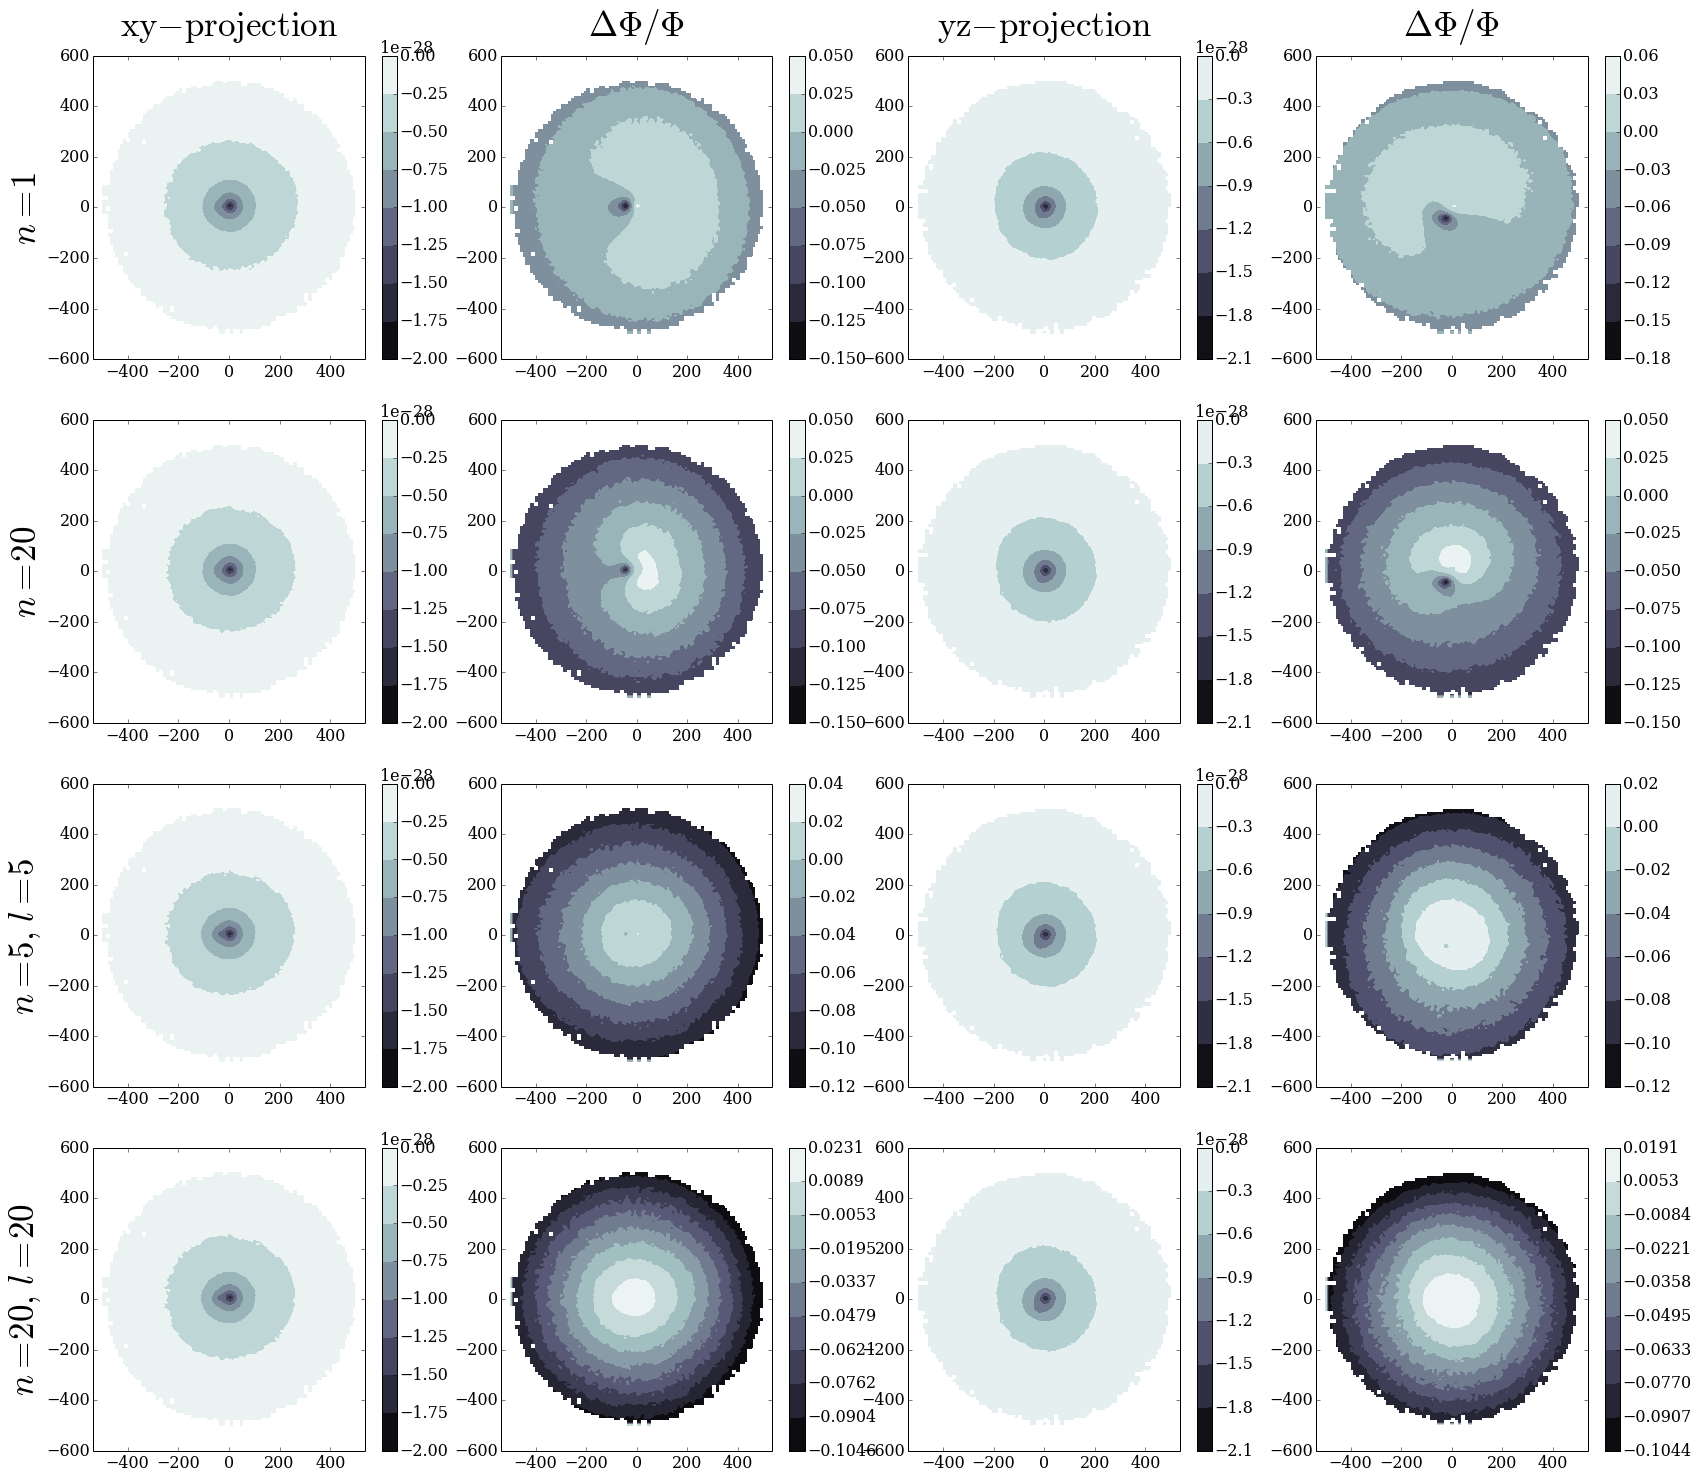

In [136]:
plt.figure(figsize=(28, 25))

plt.subplot(4,4,1)
plt.title('$\mathrm{xy-projection}$', fontsize=35, y=1.05)
plt.contourf(x_MWLMC2_f, y_MWLMC2_f, potMWLMC2_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=1$', fontsize=35)
plt.colorbar()

plt.subplot(4,4,2)
plt.title('$\Delta \Phi / \Phi$', fontsize=35, y=1.05)
plt.contourf(x_MWLMC2f_r, y_MWLMC2f_r, potMWLMC2f_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,3)
plt.title('$\mathrm{yz-projection}$', fontsize=35, y=1.05)
plt.contourf(y2_MWLMC2_f, z2_MWLMC2_f, potMWLMC2yz_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,4)
plt.title('$\Delta \Phi / \Phi$', fontsize=35, y=1.05)
plt.contourf(y2_MWLMC2f_r, z2_MWLMC2f_r, potMWLMC2yzf_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,5)
plt.contourf(x_MWLMC4_f, y_MWLMC4_f, potMWLMC4_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=20$', fontsize=35)
plt.colorbar()

plt.subplot(4,4,6)
plt.contourf(x_MWLMC4f_r, y_MWLMC4f_r, potMWLMC4f_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,7)
plt.contourf(y2_MWLMC4_f, z2_MWLMC4_f, potMWLMC4yz_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,8)
plt.contourf(y2_MWLMC4f_r, z2_MWLMC4f_r, potMWLMC4yzf_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()


plt.subplot(4,4,9)
plt.contourf(x_MWLMC5_f, y_MWLMC5_f, potMWLMC5_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.ylabel('$n=5,\ l=5$', fontsize=35)

plt.colorbar()

plt.subplot(4,4,10)
plt.contourf(x_MWLMC5f_r, y_MWLMC5f_r, potMWLMC5f_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,11)
plt.contourf(y2_MWLMC5_f, z2_MWLMC5_f, potMWLMC5yz_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,12)
plt.contourf(y2_MWLMC5f_r, z2_MWLMC5f_r, potMWLMC5yzf_r, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()

plt.subplot(4,4,13)
plt.contourf(x_MWLMC6_f, y_MWLMC6_f, potMWLMC6_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
plt.ylabel('$n=20,\ l=20$', fontsize=35)
#plt.xlabel('$x[kpc]$', fontsize=30)

levels6 = np.linspace(np.nanmin(potMWLMC6f_r), np.nanmax(potMWLMC6f_r), 10)


plt.subplot(4,4,14)
plt.contourf(x_MWLMC6f_r, y_MWLMC6f_r, potMWLMC6f_r, origin='lower', cmap = plt.cm.bone, levels=levels6)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)

plt.subplot(4,4,15)
plt.contourf(y2_MWLMC6_f, z2_MWLMC6_f, potMWLMC6yz_f, origin='lower', cmap = plt.cm.bone)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)


levels5 = np.linspace(np.nanmin(potMWLMC6yzf_r), np.nanmax(potMWLMC6yzf_r), 10)

plt.subplot(4,4,16)
plt.contourf(y2_MWLMC6f_r, z2_MWLMC6f_r, potMWLMC6yzf_r, origin='lower', cmap = plt.cm.bone, levels=levels5)
plt.axis('equal')
plt.colorbar()
#plt.xlabel('$x[kpc]$', fontsize=30)

plt.savefig('MWLMCf_pot_all.png', dpi=300, bbox_inches='tight')

In [97]:
pot_factor = G_c/43007.1*1E10 
x_MWLMC1f, y_MWLMC1f, potMWLMC1f = pot_contour(MWLMCf_t[:,0], MWLMCf_t[:,1], MWLMCf_pot_t*pot_factor.value, 200)

In [96]:
y2_MWLMC1f, z2_MWLMC1f, potMWLMCyzf = pot_contour(MWLMCf_t[:,1], MWLMCf_t[:,2], MWLMCf_pot_t*pot_factor.value, 200)

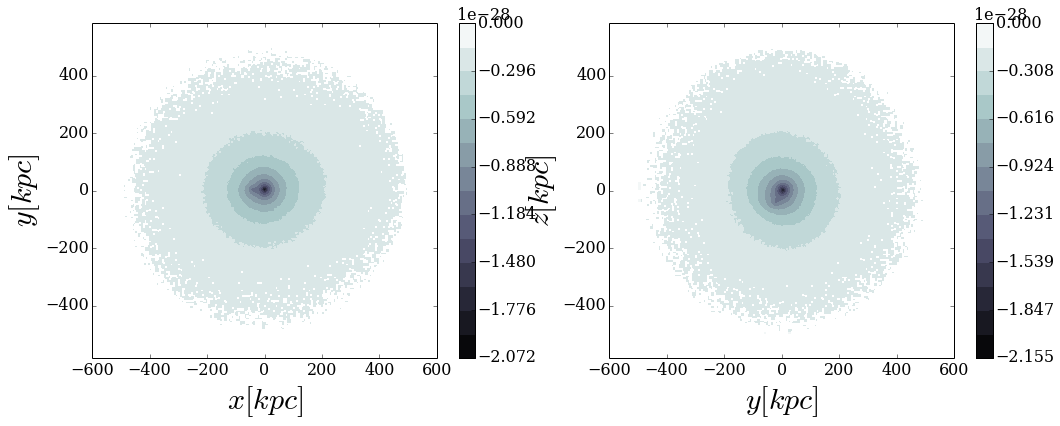

In [134]:
levels3 = np.linspace(np.nanmin(potMWLMC1f), np.nanmax(potMWLMC1f), 15)
levels4 = np.linspace(np.nanmin(potMWLMCyzf), np.nanmax(potMWLMCyzf), 15)

plt.figure(figsize=(17, 6))
plt.subplot(1,2,1)
plt.contourf(x_MWLMC1f, y_MWLMC1f, potMWLMC1f, origin='lower', cmap = plt.cm.bone,levels=list(levels3))
plt.axis('equal')
plt.colorbar()
plt.ylabel('$y[kpc]$', fontsize=30)
plt.xlabel('$x[kpc]$', fontsize=30)
#plt.title('$\Phi_{N-Body}$', fontsize=35, y=1.05)

plt.subplot(1,2,2)
plt.contourf(y2_MWLMC1f, z2_MWLMC1f, potMWLMCyzf, origin='lower', cmap = plt.cm.bone,levels=list(levels4))
plt.axis('equal')
plt.colorbar()
plt.ylabel('$z[kpc]$', fontsize=30)
plt.xlabel('$y[kpc]$', fontsize=30)

plt.savefig('LMCMWf_pot.png',dpi=300, bbox_inches='tight')



## Inner 100 kpc!

In [109]:
inner100f = np.where(np.sqrt(MWLMCf_t[:,0]**2.0 + MWLMCf_t[:,1]**2.0 + MWLMCf_t[:,2]**2.0)<100)[0]
inner100i = np.where(np.sqrt(MWLMCi_t[:,0]**2.0 + MWLMCi_t[:,1]**2.0 + MWLMCi_t[:,2]**2.0)<100)[0]

x100i = MWLMCi_t[inner100i,0]
y100i = MWLMCi_t[inner100i,1]
z100i = MWLMCi_t[inner100i,2]
pot100i = MWLMCi_pot_t[inner100i]*pot_factor.value

x100f = MWLMCf_t[inner100f,0]
y100f = MWLMCf_t[inner100f,1]
z100f = MWLMCf_t[inner100f,2]
pot100f = MWLMCf_pot_t[inner100f]*pot_factor.value


In [110]:
x100_MWLMC1f, y100_MWLMC1f, pot100MWLMC1f = pot_contour(x100f, y100f, pot100f, 200)
y100_MWLMC1f, z100_MWLMC1f, pot100MWLMC1yzf = pot_contour(y100f, z100f, pot100f, 200)

x100_MWLMC1i, y100_MWLMC1i, pot100MWLMC1i = pot_contour(x100i, y100i, pot100i, 200)
y100_MWLMC1i, z100_MWLMC1i, pot100MWLMC1yzi = pot_contour(y100i, z100i, pot100i, 200)

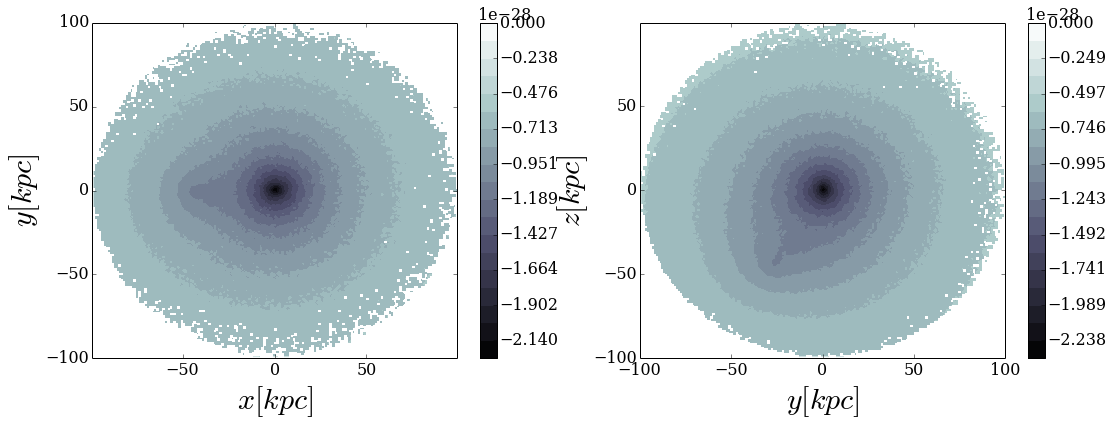

In [127]:
levels1 = np.linspace(np.nanmin(pot100MWLMC1f), np.nanmax(pot100MWLMC1f), 20)
levels2 = np.linspace(np.nanmin(pot100MWLMC1yzf), np.nanmax(pot100MWLMC1yzf), 20)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.contourf(x100_MWLMC1f, y100_MWLMC1f, pot100MWLMC1f, origin='lower', cmap = plt.cm.bone, levels=list(levels1))
#plt.axis('equal')
plt.colorbar()
plt.ylabel('$y[kpc]$', fontsize=30)
plt.xlabel('$x[kpc]$', fontsize=30)
#plt.title('$\Phi_{N-Body}$', fontsize=35, y=1.05)

plt.subplot(1,2,2)
plt.contourf(y100_MWLMC1f, z100_MWLMC1f, pot100MWLMC1yzf, origin='lower', cmap = plt.cm.bone, levels=list(levels2))
#plt.axis('equal')
plt.colorbar()
plt.ylabel('$z[kpc]$', fontsize=30)
plt.xlabel('$y[kpc]$', fontsize=30)

plt.savefig('LMCMWf_inner_pot.png',dpi=300, bbox_inches='tight')

In [119]:
print levels1

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


In [122]:
np.nanmin(pot100MWLMC1f)

-2.2588945835638662e-28